In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# (LARGE) Conditional Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Conditional Neural Process (no latents) for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 64
num_points = 128
num_samples = 100000
n_epochs = 30


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(3, num_points-50))


def get_model(x_dim, y_dim):
    return NeuralProcess(x_dim, y_dim,
                         XYEncoder=_DeepMLP,
                         Decoder=_DeepMLP,
                         r_dim=r_dim,
                         LatentEncoder=MLP,
                         get_cntxt_trgt=get_cntxt_trgt,
                        encoded_path="deterministic")


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))


##  Data

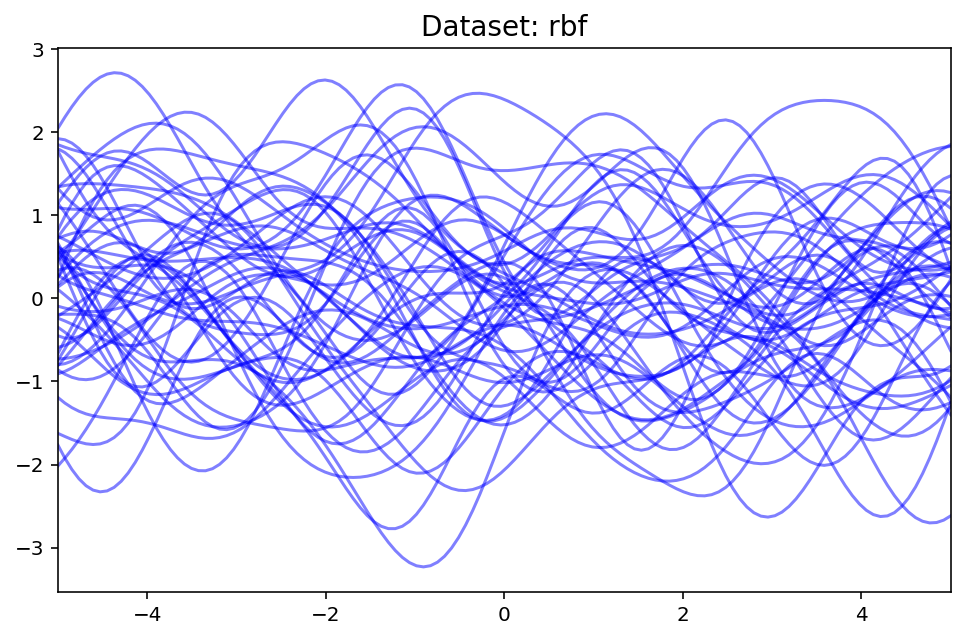

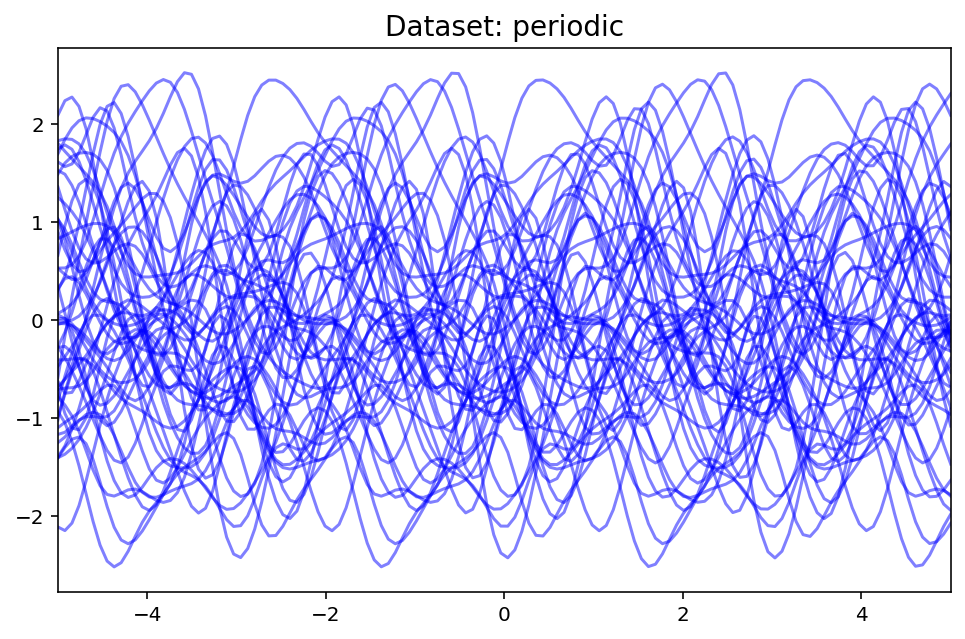

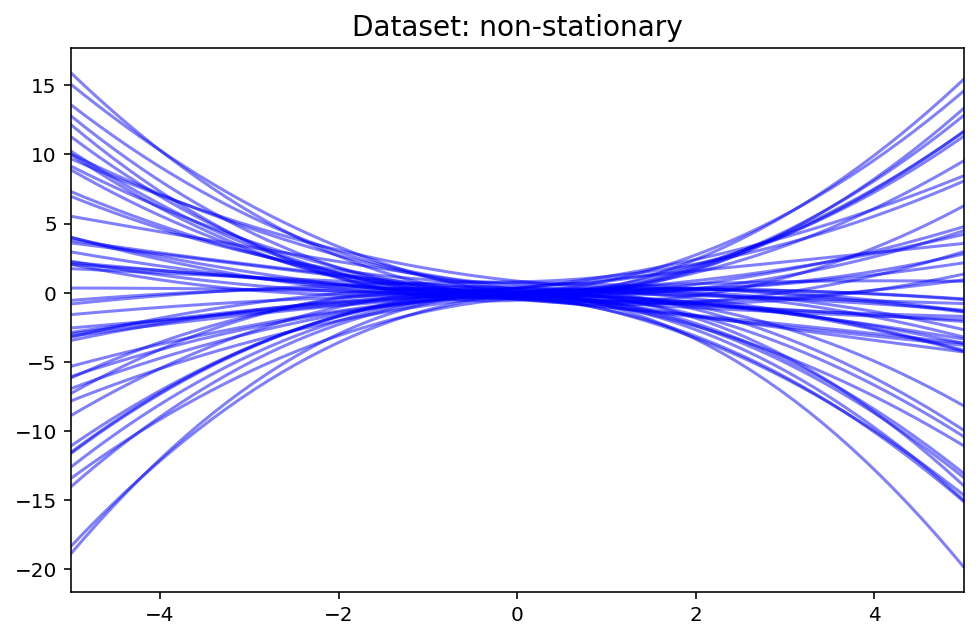

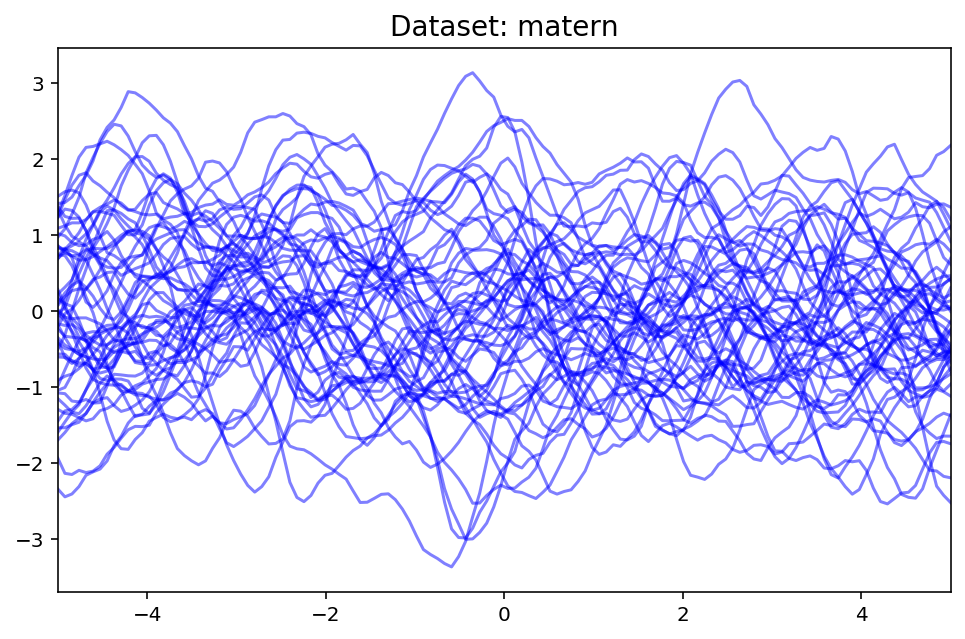

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

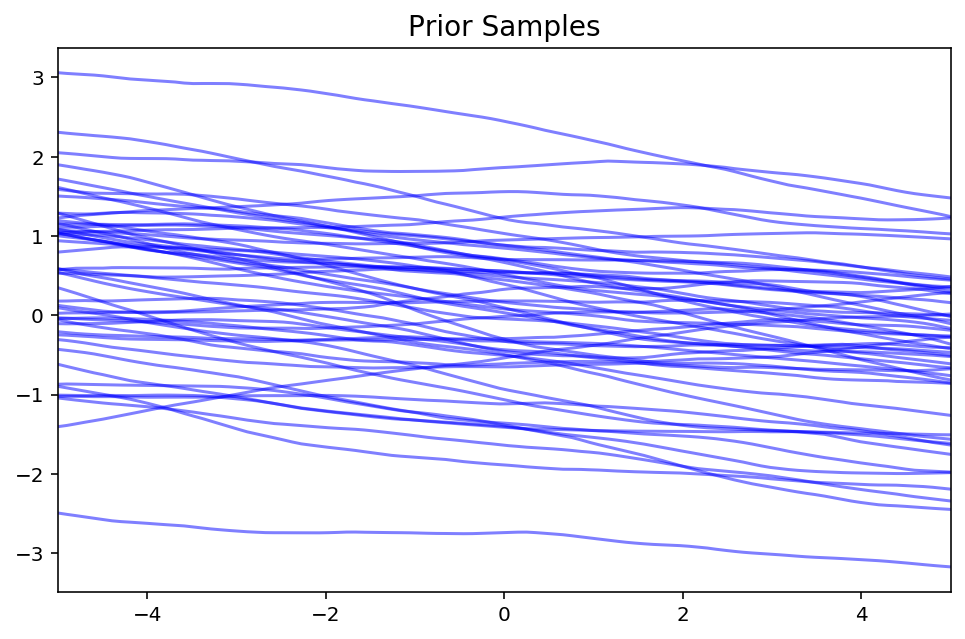

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None) # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1      126.4348  11.8097


      2       91.1437  13.3938


      3       66.7322  13.0067


      4       52.5067  11.2770


      5       39.1827  10.7767


      6       30.0366  11.2294


      7       22.8764  11.2618


      8       15.6338  9.5731


      9       10.4251  10.6703


     10        8.4806  11.2328


     11        3.2483  11.5030


     12       -4.1858  11.0506


     13       -6.3568  10.9085


     14       -7.9911  11.3185


     15      -11.3921  11.9318


     16      -17.5295  11.5889


     17      -19.9500  11.2127


     18      -20.8496  11.0436


     19      -21.7478  11.3059


     20      -23.6259  9.9362


     21      -25.4678  11.2345


     22      -26.1247  9.5987


     23      -29.5227  10.8946


     24      -30.5861  11.3821


     25      -35.9153  11.4987


     26      -34.7646  11.2805


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  epoch    train_loss      dur
-------  ------------  -------
      1      199.2163  11.2369


      2       79.9015  12.2156


      3       34.3534  12.0734


      4       11.5817  11.2749


      5      -11.5331  11.2011


      6      -27.8073  11.2690


      7      -42.1863  11.4368


      8      -52.5809  11.2864


      9      -62.4034  11.4759


     10      -66.4616  10.7931


     11      -74.6712  11.1945


     12      -79.3487  11.9834


     13      -85.5655  11.7675


     14      -82.6831  11.2869


     15      -86.1419  11.4408


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     23       48.7329  11.8005


     24       47.1977  11.2379


     25       43.0824  11.4038


     26       43.4239  11.2358


     27       42.3831  11.5665


     28       42.1664  11.1990


     29       40.0159  11.2485


     30       37.1456  11.1488


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

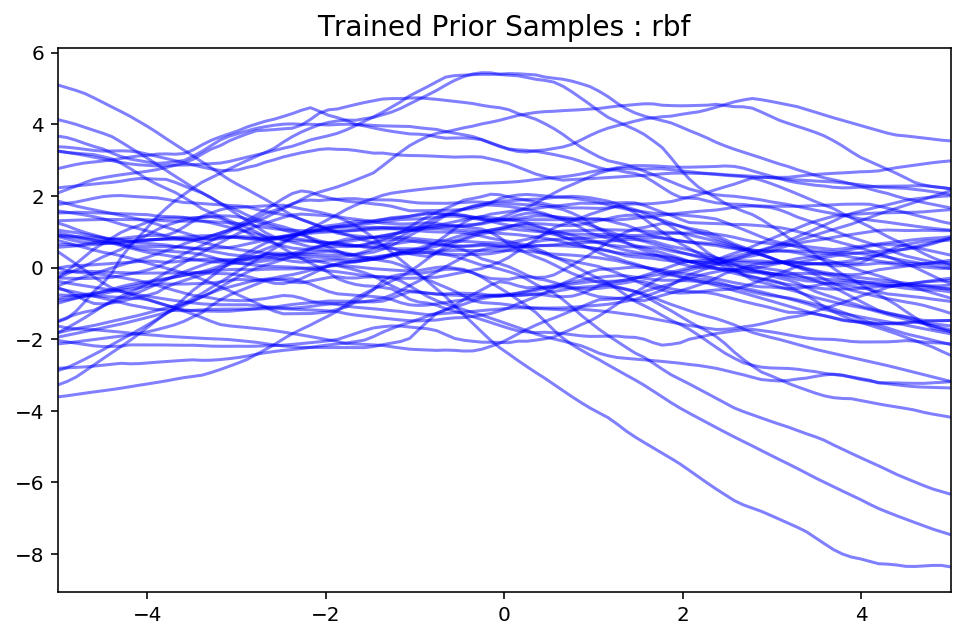

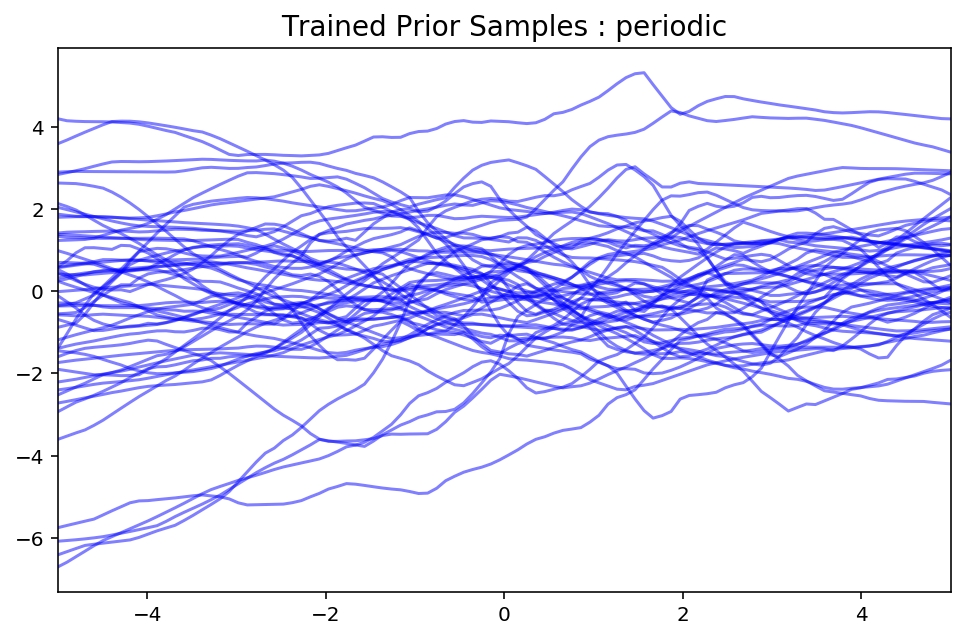

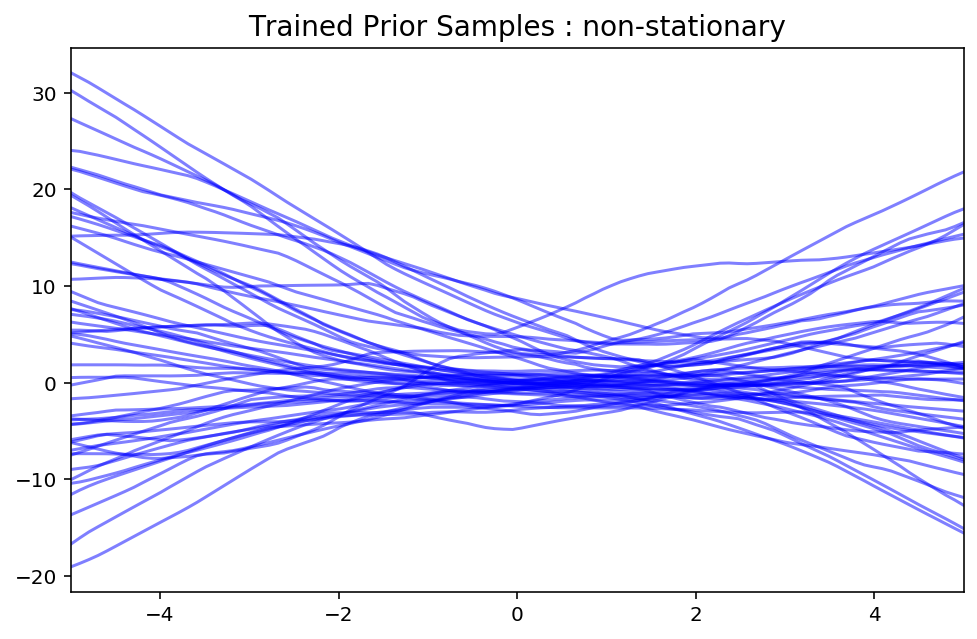

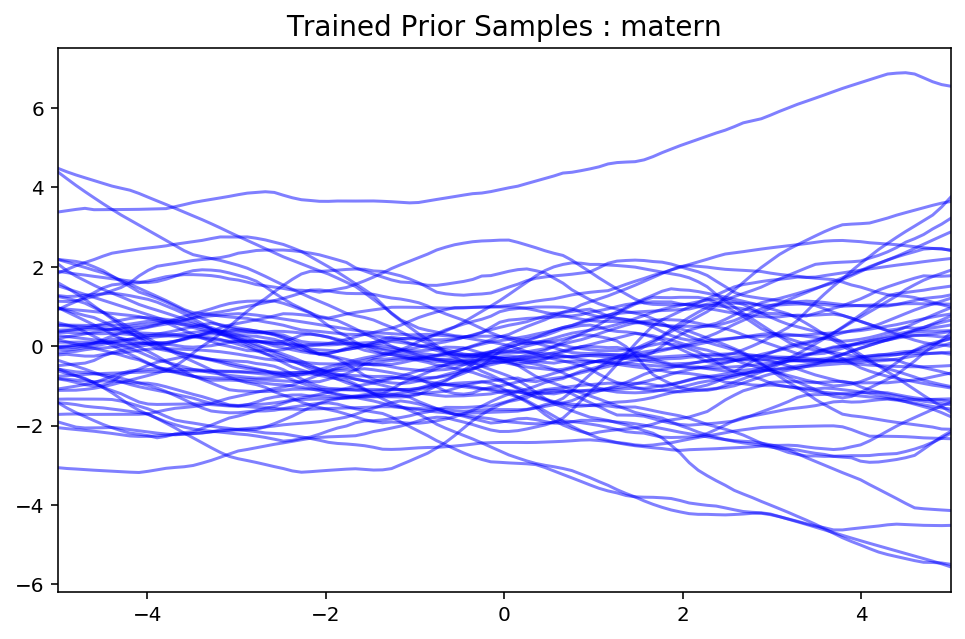

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.30194795
std: 0.4370699
std: 0.19135354
std: 0.66230315


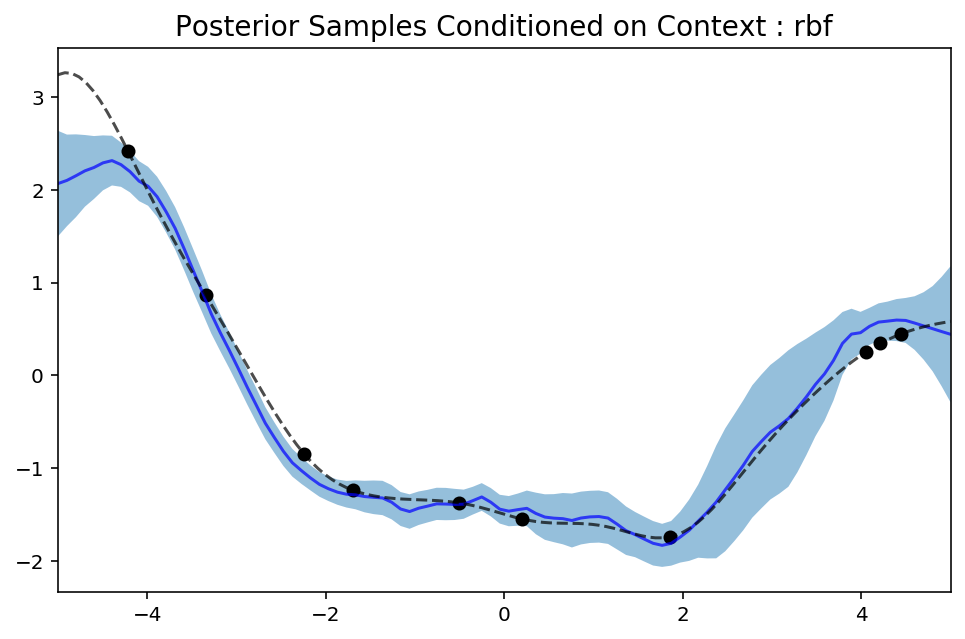

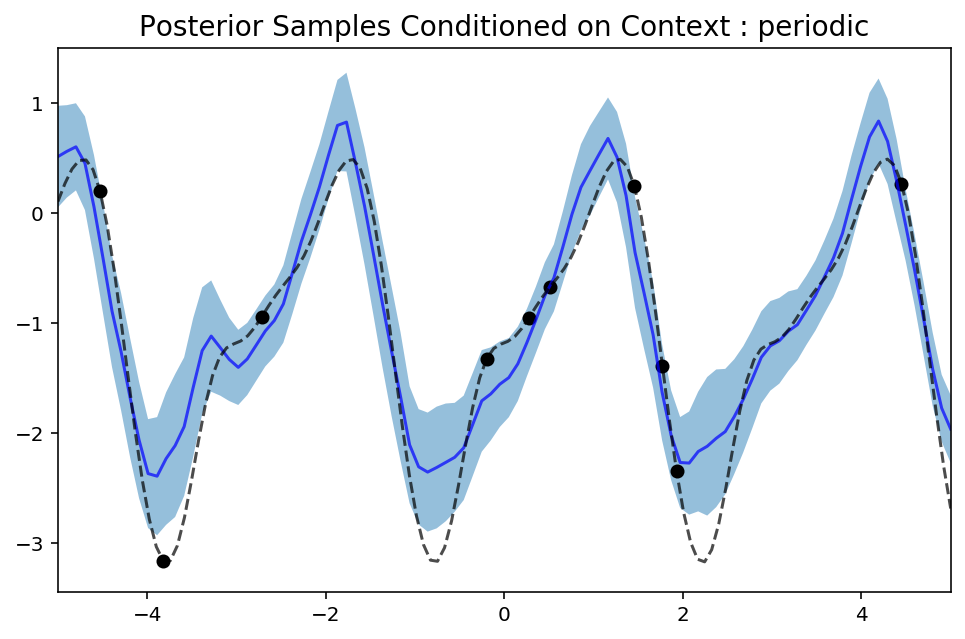

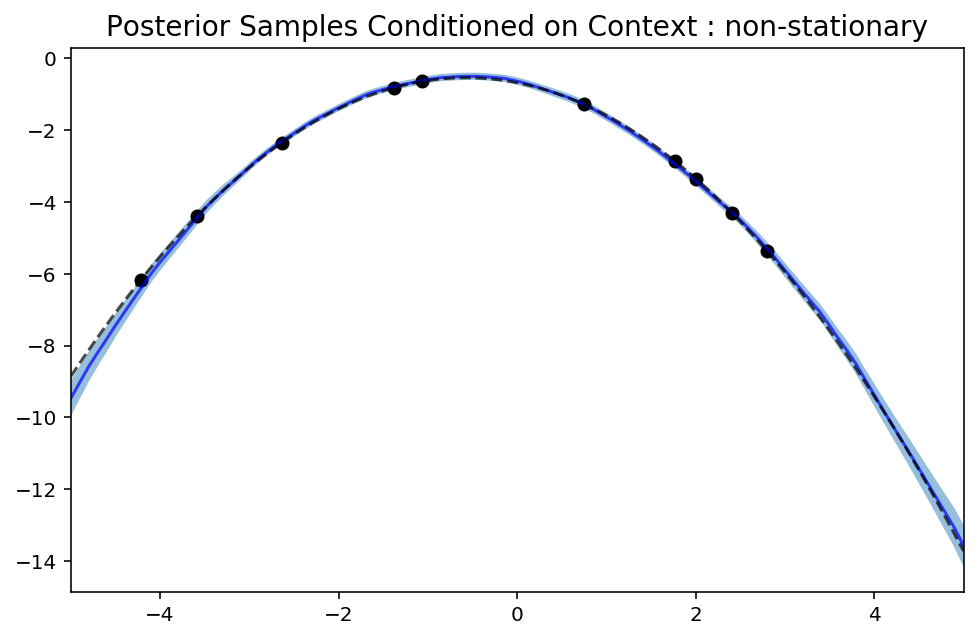

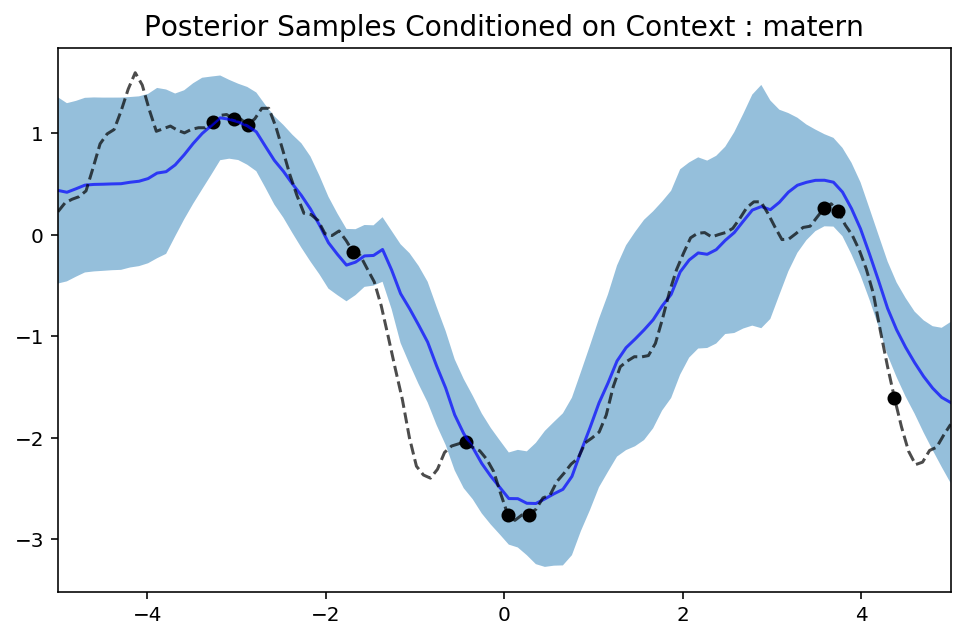

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  n_samples=1, is_plot_std=True,
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 1.0088855
std: 0.72182965
std: 2.184557
std: 1.0304695


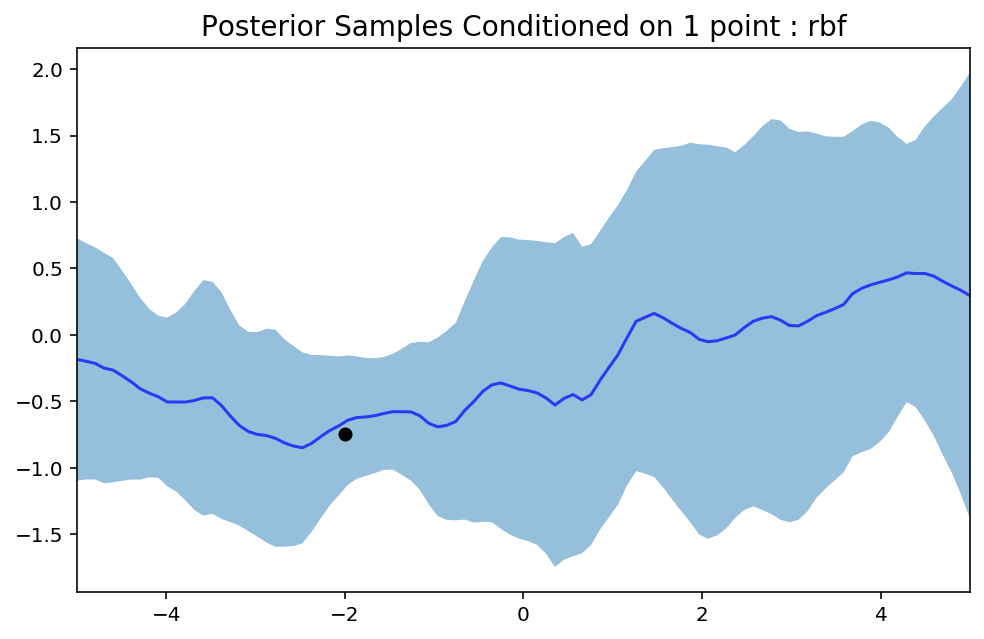

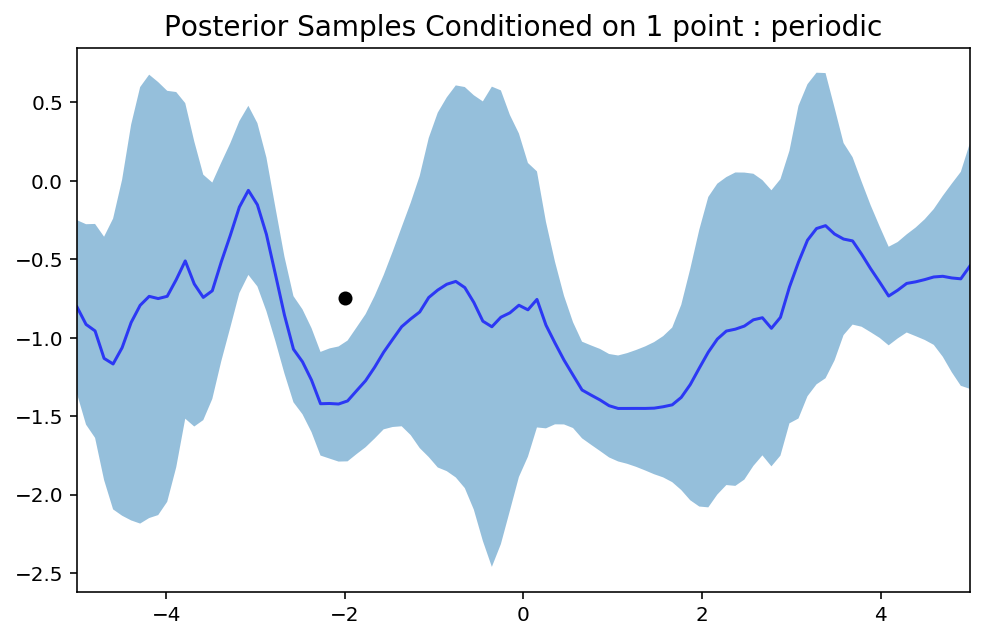

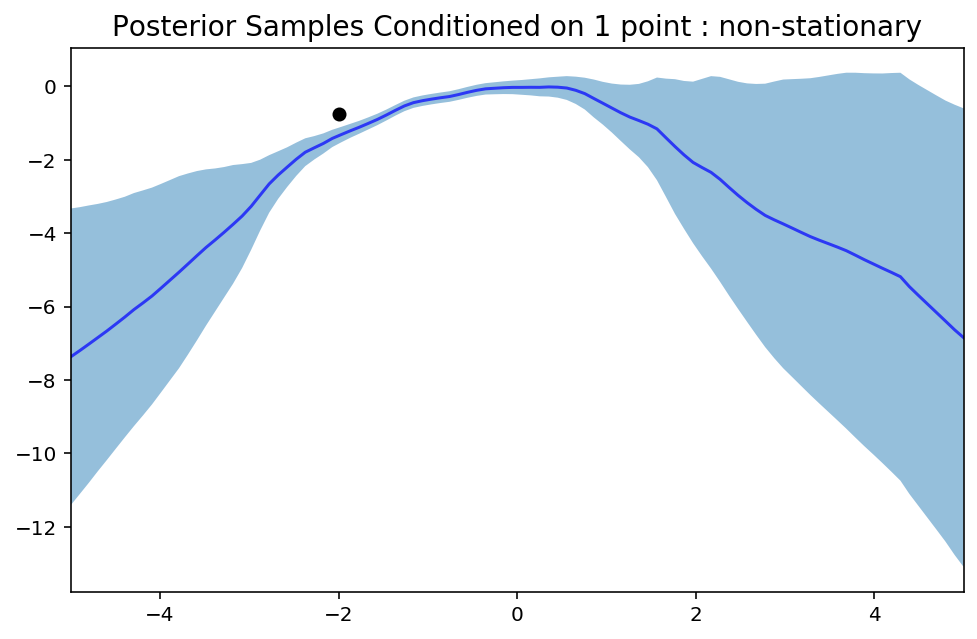

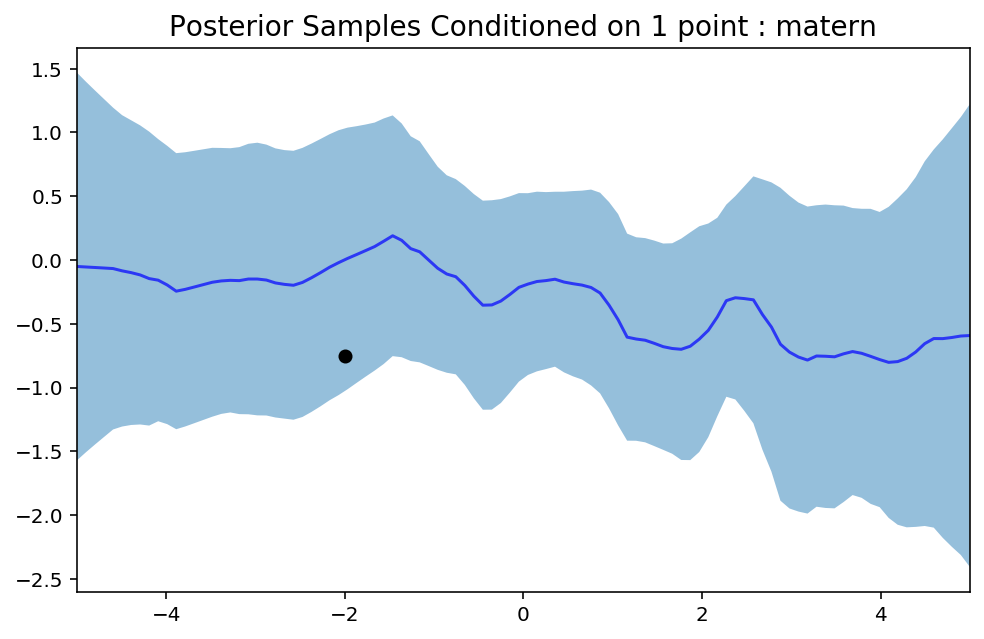

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]),  
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 0.91684693
std: 0.885673
std: 2.5344007
std: 0.94287497


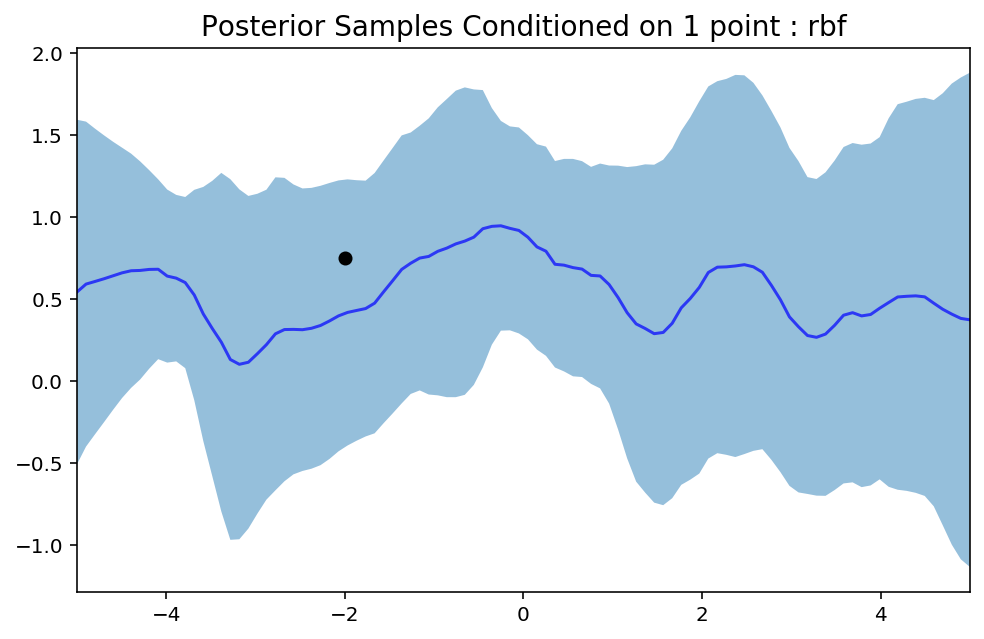

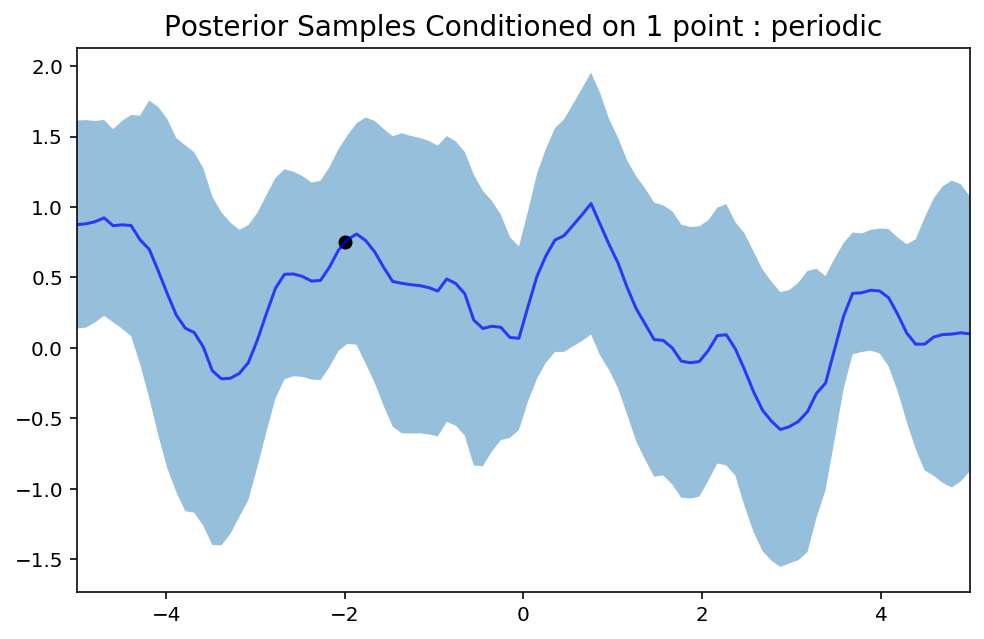

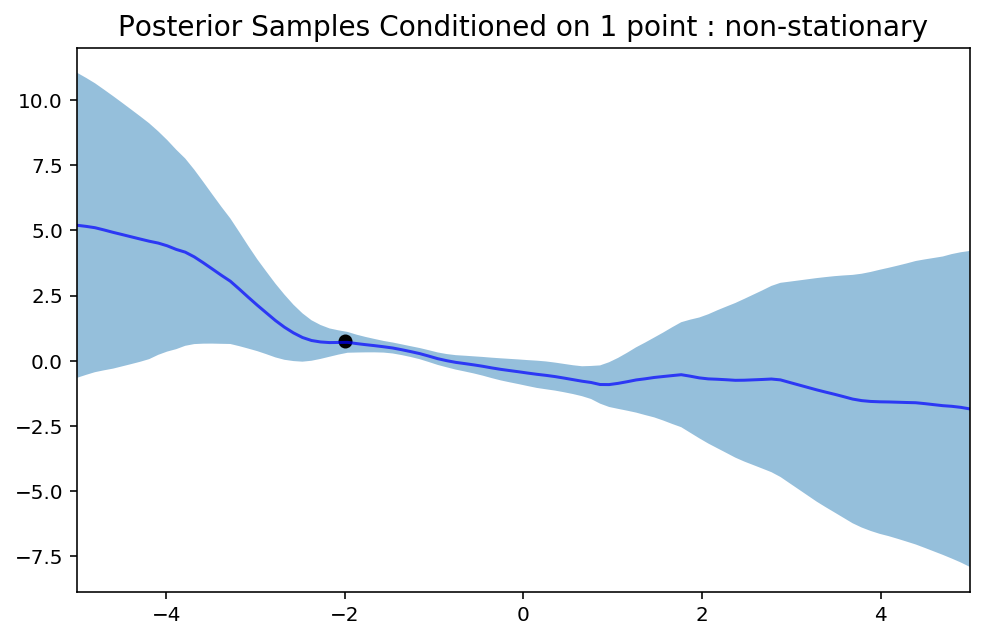

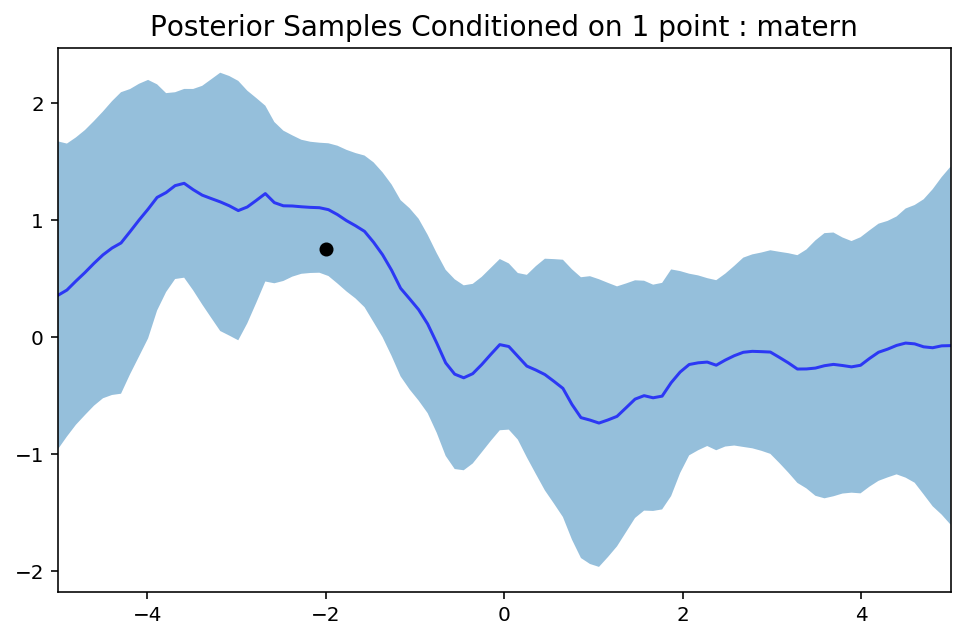

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))